<a href="https://colab.research.google.com/github/titsitits/Python_Data_Science/blob/master/8_Example_Ames_Housing_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mickaël Tits
CETIC
mickael.tits@cetic.be

# Chapitre 8 - Un exemple concret: prédiction du prix d'une maison à Ames (Iowa, USA)

Dans ce Chapitre, nous allons analyser un vrai Dataset de biens immobiliers: le "Ames Housing Dataset". A partir de ces données, nous allons développer un modèle prédictif permettant d'estimer le prix d'une maison à partir de nombreuses caractéristiques, telles que sa surface, le nombre de pièces, différents indices de qualité, etc.

Plus d'informations ici: 
https://www.kaggle.com/c/home-data-for-ml-course/overview/description

http://jse.amstat.org/v19n3/decock.pdf

Détails sur les variables du dataset: https://github.com/titsitits/Python_Data_Science/blob/master/Donn%C3%A9es/data_description.txt

## Préparation/exploration du dataset

In [0]:
import pandas as pd

ames = pd.read_csv("https://raw.githubusercontent.com/titsitits/Python_Data_Science/master/Donn%C3%A9es/train.csv")

Commençons par explorer brièvement la qualité des données.

On a 1460 observations (maisons), et 81 variables dont un Id et le prix de vente (SalePrice). 19 variables contiennent des données invalides ou manquantes.

In [0]:
#Quelques fonctions utiles pour l'exploration

#Par soucis de lisibilité, on affichera les series comme des dataframes d'une ligne
def display_series(series):  
  display(series.to_frame().transpose())
  
#Corrélation entre deux colonnes
def col_corr(df,col1,col2):  
  return df[[col1,col2]].corr().values[0,1]

#Pour analyser l'effet d'une variable continue sur une autre, on peut extraire deux groupes (chaque côté de la médiane), et afficher un boxplot par groupe
def mediangroups_boxplot_comparison(df, group_col, comparison_col):
  df["above_median"] = df[group_col] > df[group_col].quantile(0.5)
  df.boxplot(comparison_col, by = "above_median")
  df.pop("above_median")

#Pour analyser l'effet d'une variable continue sur une autre, on peut extraire deux groupes (chaque côté de la médiane), et calculer la moyenne par groupe
def mediangroups_mean_comparison(df, group_col, comparison_col):  
  means = df.groupby(df[group_col] > df[group_col].quantile(0.5))[comparison_col].mean()
  means.index = ['Below','Above']
  return means

#Idem en séparant les groupes avec la moyenne
def meangroups_mean_comparison(df, group_col, comparison_col):
  means = df.groupby(df[group_col] > df[group_col].mean())[comparison_col].mean()
  means.index = ['Below','Above']
  return means

In [0]:
print(ames.shape)
print(list(ames.columns))

#Colonnes incomplètes
counts = ames.count()
incomplete = counts[counts < len(ames)]
display_series(incomplete.sort_values())
len(incomplete.index)

(1460, 81)
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtQual,BsmtCond,MasVnrArea,MasVnrType,Electrical
0,7,54,91,281,770,1201,1379,1379,1379,1379,1379,1422,1422,1423,1423,1423,1452,1452,1459


19

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b933b7ac8>]],
      dtype=object)

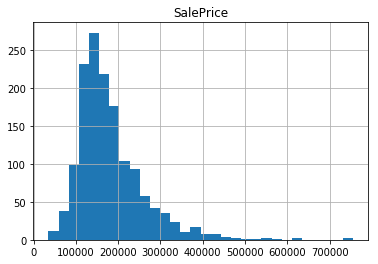

In [0]:
ames.hist("SalePrice", bins = 30)

### Données manquantes

Après vérification de la description des variables, on remarque que les variables catégorielles contiennent des "NA" comme catégories, et qui sont automatiquement interprété comme des NaN par pandas. Pour éviter ce problème, on peut soit explicitement omettre les NaNs lors de la lecture:
ames = pd.read_csv("https://raw.githubusercontent.com/titsitits/Python_Data_Science/master/Donn%C3%A9es/train.csv", na_filter = False)
On peut aussi corriger le dataframe en remplissant tous les NaN, ou seulement pour les variables catégorielles

In [0]:
#Pour vérifier le type d'une colonne: .dtypes()
display_series(ames.dtypes)
#Les variables catégorielles sont du type "object"

#Vérifions les données incomplètes uniquement:
display_series(ames[incomplete.index].dtypes)
#Trois variables de type "float64" contiennent des NaN

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,int64,int64,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,int64,object,int64,int64,int64,object,...,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,int64,int64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,object,int64


,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,float64,object,object,float64,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object


#### Variables catégorielles

In [0]:
#Pour les variables catégorielles, remplissons les NaN
cat_columns = ames.columns[ames.dtypes == 'object']
for col in cat_columns:
  ames[col] = ames[col].fillna('Nothing')

#### Variables numériques

On peut recommencer l'exploration pour les variables numériques.

In [0]:
counts = ames.count()
incomplete = counts[counts < len(ames)]
display_series(incomplete.sort_values())


,LotFrontage,GarageYrBlt,MasVnrArea
0,1201,1379,1452


In [0]:
#Mean price for NaNs and for non-NaNs
display_series(ames.groupby(ames.LotFrontage.isna())["SalePrice"].mean())
display_series(ames.groupby(ames.GarageYrBlt.isna())["SalePrice"].mean())
display_series(ames.groupby(ames.MasVnrArea.isna())["SalePrice"].mean())

LotFrontage,False,True
SalePrice,180770.480433,181620.073359


GarageYrBlt,False,True
SalePrice,185479.51124,103317.283951


MasVnrArea,False,True
SalePrice,180615.063361,236484.25


L'absence de LotFrontage n'a pas d'influence sur le prix. Les deux autres variables ont une influence. GarageYrBlt = NaN signifie probablement qu'il n'y a pas de garage (ce qui diminue la valeur), et MasVnrArea = NaN semble augmenter la valeur.

0.4774930470957107


,Below,Above
SalePrice,157293.746835,215662.741117


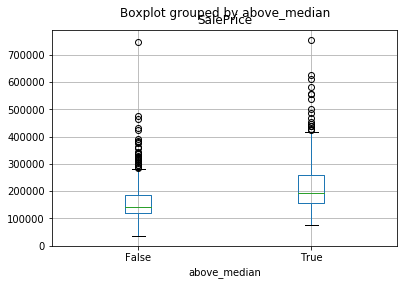

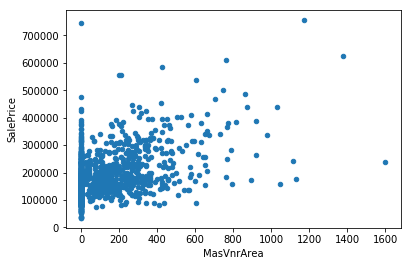

In [0]:
#Analysons la relation entre "MasVnrArea" et le prix
print(col_corr(ames,"MasVnrArea","SalePrice"))
display_series(mediangroups_mean_comparison(ames,"MasVnrArea","SalePrice"))
mediangroups_boxplot_comparison(ames,"MasVnrArea","SalePrice")
ames.plot.scatter("MasVnrArea","SalePrice")
#Il semblerait que l'influence soit positive

#Une possibilité pour prendre en compte cette information est de remplacer les NaN la moyenne de la colonne (ce qui minimisera l'influence de la variable pour ces observations particulières), et d'ajouter une colonne "isnan_MasVnrArea" pour garder l'information
#La relation entre "MasVnrArea" et "SalePrice" ne devrait pas être trop faussée de cette manière, étant donné que le nombre de NaN est assez faible (81).
ames["isnan_MasVnrArea"] = ames.MasVnrArea.isna().astype(int) #.astype(int) permet de rendre la variable numérique. #.astype(str) permettrait d'en faire une variable catégorielle
ames["MasVnrArea"] = ames["MasVnrArea"].fillna(ames["MasVnrArea"].mean())

0.35179909657067854


,Below,Above
SalePrice,162409.166279,207455.105


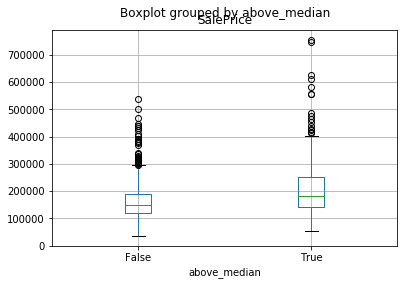

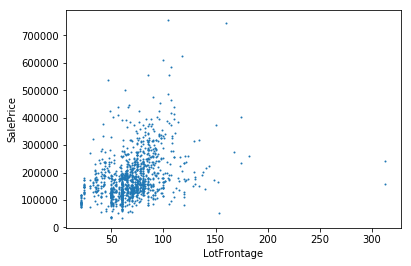

In [0]:
#Analysons la relation entre "LotFrontage" et le prix
print(col_corr(ames,"LotFrontage","SalePrice"))
display_series(mediangroups_mean_comparison(ames,"LotFrontage","SalePrice"))
mediangroups_boxplot_comparison(ames,"LotFrontage","SalePrice")
ames.plot.scatter("LotFrontage","SalePrice", s = 1)

#Ajoutons une variable isnan_LotFrontage pour pouvoir utiliser cette information dans notre modèle plus tard:
ames["isnan_LotFrontage"] = ames.LotFrontage.isna().astype(int)
#Ensuite, étant donné le grand nombre de NaNs (~18%), il est préférable (dans une premier temps) de ne pas utiliser cette variable en remplaçant les NaN par la moyenne
#Une autre possibilité serait d'entraîner un modèle de régression pour prédire ces données manquantes à partir des autres variables.
out = ames.pop("LotFrontage")

On ne peut pas considérer Lotfrontage = NaN comme 0, auquel cas le prix moyen serait plus faible que pour les autres maisons. Il est préférable d'omettre la variable vu la quantité de NaN (plus de 10%). Remplacer NaN par une valeur apporterait des informations erronnées, et omettre les observations réduirait significativement la taille du dataset.

,count,mean,std,min,25%,50%,75%,max
GarageArea,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


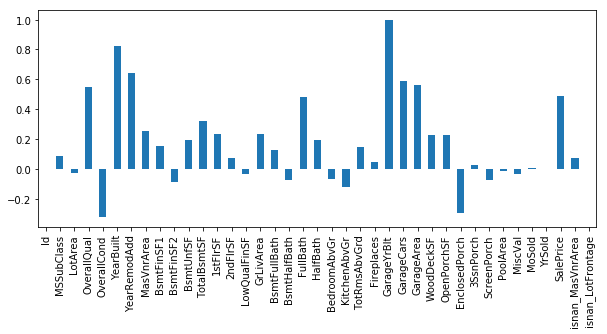

In [0]:
#Concernant l'année de construction du garage, une valeur nulle n'aurait aucun sens.
#On peut vérifier que la NaN correspond simplement à une absence de garage. En effet, leur surface est toujours nulle:
display_series(ames[ames.GarageYrBlt.isna()].GarageArea.describe())
#L'information sur l'absence de garage est donc déjà présente dans une autre variable. 

ames.corrwith(ames["GarageYrBlt"]).plot.bar(figsize = (10,4))
#On remarque aussi que l'année de construction du garage est logiquement corrélée avec l'année de construction du bien.
#Pour remplir les quelques NaN, on peut éventuellement "simuler" une date de construction du garage avec l'année de construction.
ames["GarageYrBlt"] = ames["GarageYrBlt"].fillna(ames["YearBuilt"])

#### Suppression des variables inutiles

In [0]:
out = ames.pop("Id")

#### Tout en une fonction

In [0]:
#Il est intéressant de redéfinir le pipeline de correction avec une fonction, pour pouvoir le réappliquer plus tard sur de nouvelles données (le set de test par exemple)

def clean_df(df):
  #Fill categorical columns
  cat_columns = df.columns[df.dtypes == 'object']
  for col in cat_columns:
    df[col] = df[col].fillna('Nothing')
  
  #Clean MasVnrArea
  df["isnan_MasVnrArea"] = df.MasVnrArea.isna().astype(int)
  df["MasVnrArea"] = df["MasVnrArea"].fillna(df["MasVnrArea"].mean())
  
  #Clean LotFrontage
  df["isnan_LotFrontage"] = df.LotFrontage.isna().astype(int)
  #Ensuite, étant donné le grand nombre de NaNs (~18%), il est préférable (dans une premier temps) de ne pas utiliser cette variable en remplaçant les NaN par la moyenne
  #Une autre possibilité serait d'entraîner un modèle de régression pour prédire ces données manquantes à partir des autres variables.
  df = df.drop("LotFrontage", axis=1)
  
  #clean GarageYrBlt
  df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["YearBuilt"])
  
  #Suppression des variables inutiles
  out = df.pop("Id")
  
  return df

## Sélection de variables prédictives

In [0]:
from sklearn.model_selection import train_test_split

train_ames, val_ames = train_test_split(ames, test_size = 0.3)

### Analyse de corrélation (variables continues)

Remarque: les méthodes pandas.DataFrame.corr() et .corrwith() omettent automatiquement les variables non-numériques.

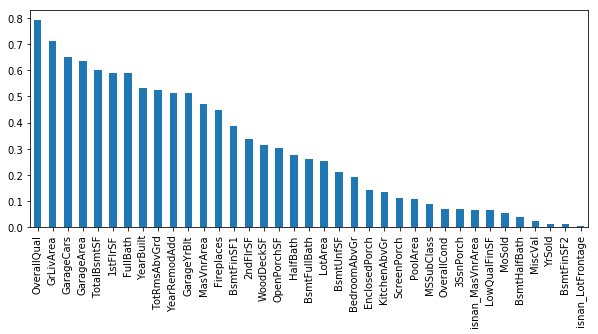

In [0]:
from matplotlib import pyplot as plt

#corrélations des variables avec le prix
corr_with_price = train_ames.corrwith(train_ames["SalePrice"])

#On trie les variables selon la valeur absolue de leur corrélation avec le prix
best_features = corr_with_price.abs().sort_values(ascending=False)

# On ne évidemment peut utiliser le label comme variable prédictive
best_features.pop("SalePrice")

best_features.plot.bar(figsize=(10,4))

best_features = best_features.index.to_list()

### Analyse basique d'effet des variables continues

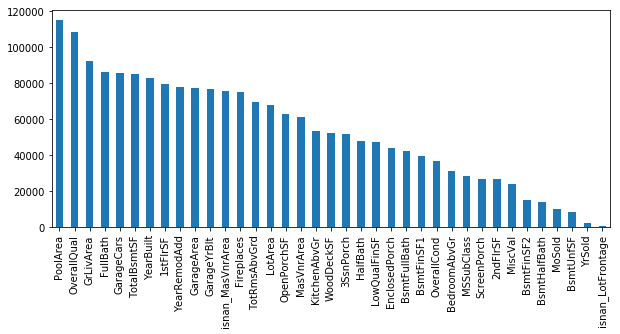

In [0]:
#Analyse de l'effet
continuous_col = train_ames.columns[(ames.dtypes == 'int64') | (ames.dtypes == 'float64')]

delta_mean = []

for col in list(continuous_col):  
  means = meangroups_mean_comparison(train_ames, col, "SalePrice")
  delta_mean.append( means[1] - means[0] )

best_features_effects = pd.Series(delta_mean, continuous_col).abs().sort_values(ascending = False)
best_features_effects = best_features_effects.drop("SalePrice")
best_features_effects.plot.bar(figsize=(10,4))

best_features_effects = best_features_effects.index.to_list()

Les résultats sont assez similaires. En réalité, les différences principales se trouvent pour les variables dont la distribution est fortement asymmétrique (e.g.: PoolArea est la plupart du temps 0, tout comme isnan_MasVnrArea)

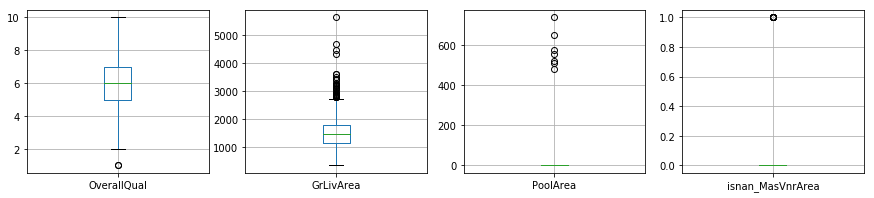

In [0]:
fig, axes = plt.subplots(1,4,figsize = (15,3))
ames.boxplot("OverallQual", ax = axes[0])
ames.boxplot("GrLivArea", ax = axes[1])
ames.boxplot("PoolArea", ax = axes[2])
ames.boxplot("isnan_MasVnrArea", ax = axes[3])

## Préparation des sets d'entraînement et de validation

### Sélection des variables prédictives (features)

In [0]:
#Prenons les cinq meilleures variables prédictives (en sa basant sur leur corrélation avec le prix, ou le delta de la moyenne)
featurelist = best_features[:5]
featurelist = best_features_effects[:5]

dataset = ames[featurelist+["SalePrice"]]

X = dataset[featurelist]
y = dataset["SalePrice"]

### Séparation des données d'entraînement et de validation

In [0]:
from sklearn.model_selection import train_test_split

trainids, valids = train_test_split(np.array(range(len(ames))), test_size = 0.4)

Xtrain, Xval, ytrain, yval = X.loc[trainids], X.loc[valids], y.loc[trainids], y.loc[valids]

#Ce code est équivalent, mais le but ici est de garder les mêmes ids pour comparer plusieurs modèles (ou prendre leur moyenne, voir fin du notebook)
#Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.3)

## Régression linéaire

In [0]:
from sklearn.linear_model import LinearRegression

price_predictor = LinearRegression()
price_predictor.fit(Xtrain, ytrain)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE


print("R2 Scores (train, val):", price_predictor.score(Xtrain, ytrain), price_predictor.score(Xval, yval))

y_pred = price_predictor.predict(Xval)

print("biais:", np.mean(y_pred - yval.values) ) #si il est négatif: sous-évaluation (en moyenne), si il est positif: sur-évaluation
print("MAE:", MAE(yval.values, y_pred) )
print("RMSE:", np.sqrt(MSE(yval.values, y_pred)) )

#Tester en gardant ou en retirant les outliers; tester avec différentes ensembles de variables

R2 Scores (train, val): 0.7619382517924465 0.6827273459004469
biais: 4115.122061320496
MAE: 28437.620348086406
RMSE: 42020.70367212462


## Comparaison pour différents nombres de variables prédictives

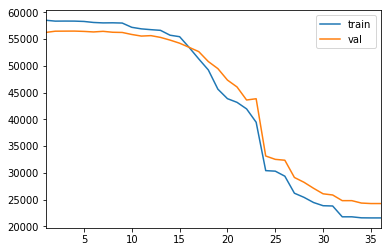

In [0]:
maes = pd.DataFrame(columns = ['train','val'])

for n in range(1,len(best_features)):

  #Choix des variables
  #featurelist = best_features[:n]
  #featurelist = best_features_effects[:n]
  
  #Commencer par les plus mauvaises
  featurelist = best_features[::-1][:n]
  #featurelist = best_features_effects[::-1][:n]
  
  
  dataset = ames[featurelist+["SalePrice"]]
  
  X = dataset[featurelist]
  y = dataset["SalePrice"]
  
  Xtrain, Xval, ytrain, yval = X.loc[trainids], X.loc[valids], y.loc[trainids], y.loc[valids]
  price_predictor.fit(Xtrain, ytrain)
  trainpred = price_predictor.predict(Xtrain)
  valpred = price_predictor.predict(Xval)
  
  maes.loc[n] = MAE(ytrain, trainpred), MAE(yval, valpred)

maes.plot()

On peut constater que les 10-12 variables prédictives les moins corrélées à SalePrice sont (logiquement) assez inefficaces pour prédire le prix.

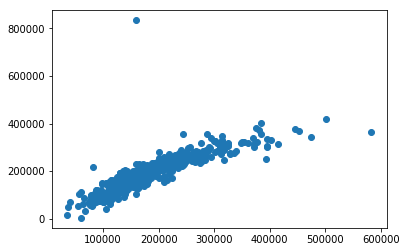

In [0]:
#Résultat avec toutes les variables
featurelist = best_features


dataset = ames[featurelist+["SalePrice"]]

X = dataset[featurelist]
y = dataset["SalePrice"]

Xtrain, Xval, ytrain, yval = X.loc[trainids], X.loc[valids], y.loc[trainids], y.loc[valids]

price_predictor.fit(Xtrain, ytrain)
trainpred = price_predictor.predict(Xtrain)
valpred = price_predictor.predict(Xval)

MAE(ytrain, trainpred), MAE(yval, valpred)
plt.scatter(yval,price_predictor.predict(Xval))

On constate que le nuage de doit semble former une légère courbe. Cela semble indiquer qu'il existe des relations non-linéaires, telles que des relations polynomiales entre les variables et le prix. La régression linéaire se base en effet sur l'hypothèse très simpliste que les relations seraient linéaires. Si on revisualise les nuages de points plus haut montrant l'interactions entre différentes variables (comme 'OverallQual') et le prix, on constate que la relation et plutôt quadratique que linéaire.

Une variation de la régression linéaire, appelée régression polynomiale, permet de facilement prendre en compte de potentielles interactions non-linéaires entre les variables, en créant de nouvelles variables à partir de polynômes des variables d'origine. Bien sûr, les possibilités ne se liminent pas aux polynômes.

##Régression polynomiale

In [0]:
def add_polynomials(X):
  for col in X.columns:
    #prise en compte des carrés des variables
    X[col+"_square"] = X[col]**2
    #prise en compte des racines carrées
    X[col+"_sqrt"] = X[col]**(1/2)
    
  return X

MAE (train,val): 15970.290155876717 19965.690133741457


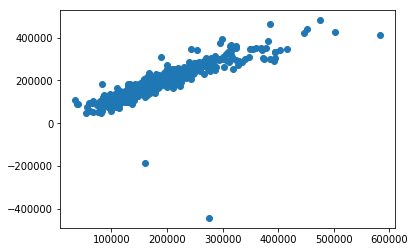

In [0]:
X = dataset[featurelist]
X = add_polynomials(X)

Xtrain, Xval, ytrain, yval = X.loc[trainids], X.loc[valids], y.loc[trainids], y.loc[valids]
price_predictor.fit(Xtrain, ytrain)
trainpred, valpred = price_predictor.predict(Xtrain), price_predictor.predict(Xval)

print("MAE (train,val):", MAE(trainpred, ytrain), MAE(valpred, yval))
plt.scatter(yval,valpred)

Les prédiction semblent suivre une ligne droite. On remarque par contre que certaines prédictions parfois sont très mauvaises, et parfois négative (c'était déjà le cas pour la régression linéaire). Selon les objectifs, il convient de définir une métrique d'évaluation appropriée: si quelques rares erreurs très grandes sont tolérables, ou si il est préférable d'avoir des prédictions globalement un peu moins précises mais sans gros écarts.
Dans tous les cas, on peut facilement améliorer les résultats en contraignant les prédictions entre des valeurs limites.

MAE (train,val): 15885.662511494605 18772.61361257344


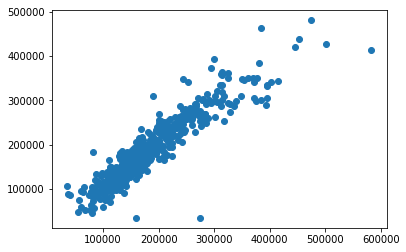

In [0]:
trainpred = trainpred.clip(ytrain.min(), ytrain.max())
valpred = valpred.clip(ytrain.min(), ytrain.max())

print("MAE (train,val):", MAE(trainpred, ytrain), MAE(valpred, yval))
plt.scatter(yval,valpred)

## Comparaison pour différents nombres d'exemples (taille du training set)

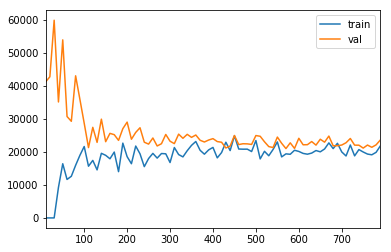

In [0]:
maes2 = pd.DataFrame(columns = ['train','val'])

for nsamples in range(10,800,10):
  
  trainset, valset = train_test_split(dataset, test_size = 660)
  
  #On extrait un sample sur le training set
  trainset_sample = trainset.sample(nsamples)
  
  Xtrain = trainset_sample[featurelist]
  ytrain = trainset_sample["SalePrice"]
  
  Xval = valset[featurelist]
  yval = valset["SalePrice"]
  
  price_predictor.fit(Xtrain, ytrain)
  
  trainpred = price_predictor.predict(Xtrain)
  valpred = price_predictor.predict(Xval)  
  trainpred = trainpred.clip(ytrain.min(), ytrain.max())
  valpred = valpred.clip(ytrain.min(), ytrain.max())  
  maes2.loc[nsamples] = MAE(ytrain, trainpred), MAE(yval, valpred)
  
maes2.plot()

On constate que les performances diminuent (l'erreur augmente) avec le nombre d'échantillons d'entraînement, et que les performances en validation sont au départ beaucoup plus faibles, ce qui est signe d'**overfitting**. En effet, en utilisant seulement 50 exemples (gauche du graphe), on remarque que le modèle compte presque autant de paramètres (un par variable prédictive, soit 36). Dans ce cas, les paramètres peuvent être adaptés aux exemples spécifiques d'entraînement pour apprendre leur prédiction presque "par coeur". Le modèle n'est alors pas générique et fonctionne mal sur de nouvelles données (comme le montrent les faibles performances en validation). On constate ensuite que pour 400 échantillons d'entraînement, les performances en entraînement se stabilisent, et les performances en validation sont équivalentes, ce qui signifie que le nombre d'échantillons est suffisant (plus d'overfitting).

In [0]:
len(price_predictor.coef_)

37

## Performances réelles

Pour évaluer les performances réelles du modèles, nous pouvons utiliser un set de données qui n'a pas encore été utilisé, ni pour l'entraînement ni pour la validation. Cela permet de simuler une utilisation réelle du modèle, sur de nouvelles maisons (dont on voudrait estimer le prix). L'évaluation des performances à partir du set de validation seraient biaisée, car il a en effet permis de choisir les paramètres du modèles, en l'occurence le choix des variables prédictives (le modèle a donc été indirectement optimisé pour ces données spécifiques).

Sur la plateforme [Kaggle](https://www.kaggle.com/), pour garantir l'absence de biais lors du design du modèle, un set de test est généralement fourni séparément, et les labels ne sont volontairement pas fournis. L'utilisateur de la plateforme doit alors soumettre à la plateforme les prédictions données par le modèle développé, et reçoit le résultat de l'évaluation effectuée par la plateforme. Cela permet notamment de classer différents compétiteurs lors d'un concours: https://www.kaggle.com/competitions

Concernant le dataset utilisé, on peut soumettre des prédictions ici: https://www.kaggle.com/c/home-data-for-ml-course/overview/evaluation




In [0]:
# Vérifions déjà les performances sur le set de validation
#Régression linéaire
featurelist = best_features
dataset = ames[featurelist+["SalePrice"]]
X = dataset[featurelist]
y = dataset["SalePrice"]

Xtrain, Xval, ytrain, yval = X.loc[trainids], X.loc[valids], y.loc[trainids], y.loc[valids]

price_predictor.fit(Xtrain, ytrain)

trainpreds = price_predictor.predict(Xtrain).clip(ytrain.min(), ytrain.max())
valpreds_lin = price_predictor.predict(Xval).clip(ytrain.min(), ytrain.max())

MAE(trainpreds,ytrain.values), MAE(valpreds_lin,yval.values)

(20218.433277807322, 21960.905666734132)

In [0]:
#Régression polynomiale
X = dataset[featurelist]
X = add_polynomials(X)

Xtrain, Xval, ytrain, yval = X.loc[trainids], X.loc[valids], y.loc[trainids], y.loc[valids]

poly_predictor = LinearRegression()
poly_predictor.fit(Xtrain, ytrain)

trainpreds = poly_predictor.predict(Xtrain).clip(ytrain.min(), ytrain.max())
valpreds_poly = poly_predictor.predict(Xval).clip(ytrain.min(), ytrain.max())

MAE(trainpreds,ytrain.values), MAE(valpreds_poly,yval.values)

(15885.662511494605, 18772.61361257344)

Remarquez que vous obtiendrez des résultats différents à chaque fois que vous relancez les cellules ci-dessus: cela est dû à la séparation aléatoire des sets d'entraînement et de validation. 

Afin d'avoir un indicateur plus robuste du modèle, une possibilité serait de calculer une moyenne de ces résultats, ou d'utiliser un processus **leave-one-out** (garder une seule observation pour la validation, entraîner le modèle sur tout le reste; calculer des prédictions ainsi pour tout le dataset (sur chaque observation de validation), et calculer la MAE sur toutes les prédictions). Le désavantage de ce processus est qu'il est lourd puisqu'il nécessite l'entraînement d'un modèle pour chaque observation du dataset.

### Vérification du set de test

In [0]:
testset = pd.read_csv("https://raw.githubusercontent.com/titsitits/Python_Data_Science/master/Donn%C3%A9es/test.csv")

ids = testset['Id']

print(len(testset))

#nettoyage du testset
testset = clean_df(testset)

#Colonnes incomplètes
counts = testset.count()
incomplete = counts[counts < len(testset)]
display_series(incomplete.sort_values())
len(incomplete.index)

1459


,BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,GarageCars,GarageArea
0,1457,1457,1458,1458,1458,1458,1458,1458


8

Il reste deux observations contenant des variables invalides. On va simplement remplacer les valeurs manquantes par les moyennes. Si le nombre d'observations à nettoyer était plus conséquent, il serait pertinent d'analyser les variables à corriger.

In [0]:
for col in incomplete.index:
  testset[col] = testset[col].fillna(ames[col].mean())

### Soumission des résultats

In [0]:
dataset = ames[featurelist+["SalePrice"]]
X = dataset[featurelist]
y = dataset["SalePrice"]
#On peut ré-entraîner le modèle sur tout le dataset (entraînement+validation), pour le rendre potentiellement plus robuste
price_predictor.fit(X, y)

#select features
Xtest = testset[featurelist]

testpreds_lin = price_predictor.predict(Xtest).clip(ytrain.min(), ytrain.max())

submission = ids.to_frame()
submission["SalePrice"] = testpreds_lin
submission.to_csv("mysubmission_linear_regression.csv", index = False)

In [0]:
Xtest2 = add_polynomials(Xtest)

X = dataset[featurelist]
X = add_polynomials(X)
poly_predictor.fit(X, y)

testpreds_poly = poly_predictor.predict(Xtest2).clip(ytrain.min(), ytrain.max())

submission = ids.to_frame()
submission["SalePrice"] = testpreds_poly
submission.to_csv("mysubmission_polynomial_regression.csv", index = False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Exploration de base des variables catégorielles

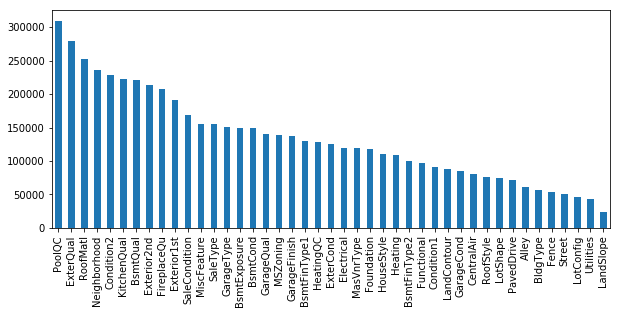

In [0]:
#Analysons l'effet de chaque variable catégorielle

from matplotlib import pyplot as plt

all_columns = ames.columns
cat_columns = ames.columns[ames.dtypes == 'object']

diffs_per_group = []

ncols = 8
ncats = len(cat_columns)
#fig, axes = plt.subplots(int(np.ceil(ncats/ncols)),ncols, figsize = (20,30))

i=0
for cat in cat_columns:  
  
  group_means = ames.groupby(cat)["SalePrice"].mean()
  diffs_per_group.append(group_means.max() - group_means.min())
  
  #Bonus: vous pouvez afficher les graphes pour chaque groupe
  #plt.figure(figsize=(10,3))
  #group_means.plot.bar()
  #ax = axes[int(i/ncols), int(i%ncols)]
  #ames.boxplot("SalePrice", by=cat, ax = ax)
  i=i+1

best_cats = pd.Series(diffs_per_group, list(cat_columns)).abs().sort_values(ascending = False)
best_cats.plot.bar(figsize=(10,4))

best_cats = best_cats.index.to_list()

## Bonus - Un algorithme plus moderne: catboost

In [0]:
#Installer un nouveau package: on appelle une ligne de commande linux grâce au symbole "!". On utilise le gestionnaire de packages python pip pour installer un nouveau package
!pip install catboost

In [0]:
contfeatures = featurelist#[:10]
catfeatures = best_cats#[:10]

newfeaturelist =  contfeatures + catfeatures

In [0]:
dataset = ames[newfeaturelist+["SalePrice"]]
X = dataset[newfeaturelist]

y = dataset["SalePrice"]

Xtrain, Xval, ytrain, yval = X.loc[trainids], X.loc[valids], y.loc[trainids], y.loc[valids]

In [0]:
import numpy as np
from catboost import Pool, CatBoostRegressor


cat_feature_ids = [i for i in range(len(newfeaturelist)) if newfeaturelist[i] in catfeatures]


train_pool = Pool(Xtrain.values, ytrain.values, cat_features=cat_feature_ids)
val_pool = Pool(Xval, yval, cat_features=cat_feature_ids) 
all_pool = Pool(X, y, cat_features=cat_feature_ids) 

# specify the training parameters 
model = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.2, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool, silent=True)

In [0]:
# make the prediction using the resulting model
trainpreds = model.predict(train_pool)
valpreds = model.predict(val_pool)

MAE(trainpreds,ytrain.values), MAE(valpreds,yval.values)

(10271.595071447291, 15654.080550929053)

In [0]:
# specify the training parameters 
model = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.2, 
                          loss_function='RMSE')

#entraînement du modèle, avec un critère d'arrêt lorsque les performances en validation baissent: éviter le surentraînement (overfitting)
model.fit(train_pool,eval_set = val_pool, early_stopping_rounds = 100, silent = True)

In [0]:
# make the prediction using the resulting model
trainpreds = model.predict(train_pool)
valpreds_catboost = model.predict(val_pool)

#Pour éviter de prédire des valeurs anormales, on limite les prédictions au range du set d'entraînement
trainpreds = trainpreds.clip(ytrain.min(), ytrain.max())
valpreds = valpreds.clip(ytrain.min(), ytrain.max())

MAE(trainpreds,ytrain.values), MAE(valpreds_catboost,yval.values)

(10289.80969011361, 15653.833927852947)

### Soumission des résultats

In [0]:
Xtest = testset[newfeaturelist]
test_pool = Pool(Xtest.values, cat_features=cat_feature_ids)

#Pour la soumission, on peut éventuellement réentraîner le modèle sur toutes les données d'entraînement et de validation (pour espérer avoir un modèle plus générique. Cependant: attention à l'overfitting sans critère d'arrêt)
model.fit(all_pool, silent = True)

#Prédictions
testpreds_catboost = model.predict(test_pool).clip(ytrain.min(), ytrain.max())

submission = ids.to_frame()
submission["SalePrice"] = testpreds_catboost
submission.to_csv("mysubmission_catboost.csv", index = False)

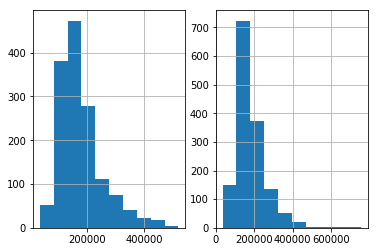

In [0]:
#Pour s'assurer de la plausibilité des résultats, on peut comparer leur distribution avec ceux du dataset d'entraînement
plt.subplot(1,2,1)
submission.SalePrice.hist()
plt.subplot(1,2,2)
ames.SalePrice.hist()

# Conclusion

Les résultats avec le fichier de baseline (sample_submission.csv) ont été obtenus avec une régression linéaire sur l'année et le mosi de vente, la surface du lot et le nombre de chambres. Les résultats de la soumission sur Kaggle donnent: 

`MAE = 59346`

Les trois soumissions proposées donnent:

* régression linéaire: 20391
* régression polynomiale: 19669
* catboost: 14328

Les algotihmes proposés prédisent donc bien mieux mieux les prix des maisons que la baseline.

Le résultat obtenu avec catboost amène à la place 522/13502 au classement de la compétition Kaggle. Il reste donc de la marge de manoeuvre pour améliorer le modèle. (Le meilleur score publique est actuellement à 11824).

Il existe de très nombreuses possibilités pour améliorer le modèle, dont par exemple:

* Vérifier plus profondément les données et supprimer d'éventuelles anomalies
* Tester d'autre ensembles de variables (en explorant plus profondément leurs relations et leur influence sur le prix)
* Créer de nouvelles variables pertinentes. Par exemple, à partir de la variable catégorielle "neighboorhood" et du prix moyen de chaque quartier, il est possible d'extraire une variable numérique indiquant le "standing" du quartier. Les nombreuses variables indiquant une échelle de qualité ("Excellent","Typical","Fair", ...) peuvent être traduites en variables numériques. Des variablesd "dummy" peuvent être extraites sur d'autres catégories.
* Les variables sont peut-être redondantes (elles apportent la même information), ce qui complexifie inutilement le modèle. Il peut être intéressant d'extraire un ensemble de variables apportant un maximum d'informations non-redondantes.
* Tester d'autres algorithmes de machine learning
* Entraîner plusieurs modèles, et calculer une moyenne pondérée des prédictions (on parle de model blending, ou de ensemble learning)

Kaggle est une excellente d'inspiration pour s'améliorer. On y trouve en effet de très nombreux notebooks (généralement en Python) proposant des idées intéressantes de feature engineering et de développement de modèles prédictifs. Par exemple, le notebook suivant est classé 26ème:
https://www.kaggle.com/itslek/stack-blend-lrs-xgb-lgb-house-prices-k-v17
La méthode propose certaines nouvelles variables prédictives simplifiées, ainsi que la moyenne pondérée de différents modèles prédictifs.



## Bonus - Un exemple basique de model blending

In [0]:
w1, w2, w3 = 0.02, 0.08, 0.9
valpreds_blend = w1*valpreds_lin + w2*valpreds_poly + w3*valpreds_catboost
MAE(yval, valpreds_blend)

15526.13441258489

In [0]:
testpreds_blend = w1*testpreds_lin + w2*testpreds_poly + w3*testpreds_catboost
submission = ids.to_frame()
submission["SalePrice"] = testpreds_catboost
submission.to_csv("mysubmission_blend.csv", index = False)


(Pas de chance: MAE = 14520, le catboost marchait mieux tout seul cette fois-ci)